# YEARLY AMOUNT SPENT PREDICTION WITH LINEAR REGRESSION

A linear regression model was created in this notebook.

# Importing Libraries and Reading Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.2f' % x)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score

df = pd.read_csv("/kaggle/input/focusing-on-mobile-app-or-website/Ecommerce Customers")
df.head()

,Email,Address,Avatar,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
0,mstephenson@fernandez.com,"835 Frank Tunnel\nWrightmouth, MI 82180-9605",Violet,34.50,12.66,39.58,4.08,587.95
1,hduke@hotmail.com,"4547 Archer Common\nDiazchester, CA 06566-8576",DarkGreen,31.93,11.11,37.27,2.66,392.20
2,pallen@yahoo.com,"24645 Valerie Unions Suite 582\nCobbborough, D...",Bisque,33.00,11.33,37.11,4.10,487.55
3,riverarebecca@gmail.com,"1414 David Throughway\nPort Jason, OH 22070-1220",SaddleBrown,34.31,13.72,36.72,3.12,581.85
4,mstephens@davidson-herman.com,"14023 Rodriguez Passage\nPort Jacobville, PR 3...",MediumAquaMarine,33.33,12.80,37.54,4.45,599.41


The variables to be used in the data were determined.

In [2]:
df = df.drop(['Email',"Address","Avatar"], axis=1) 

# Advanced Functional Exploratory Data Analysis

General structure of the data is analyzed

In [3]:
def check_df(dataframe, head=5):
    print("##################### Columns #####################")
    print(dataframe.columns)
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Columns #####################
Index(['Avg. Session Length', 'Time on App', 'Time on Website',
       'Length of Membership', 'Yearly Amount Spent'],
      dtype='object')
##################### Shape #####################
(500, 5)
##################### Types #####################
Avg. Session Length     float64
Time on App             float64
Time on Website         float64
Length of Membership    float64
Yearly Amount Spent     float64
dtype: object
##################### Head #####################
   Avg. Session Length  Time on App  Time on Website  Length of Membership  \
0                34.50        12.66            39.58                  4.08   
1                31.93        11.11            37.27                  2.66   
2                33.00        11.33            37.11                  4.10   
3                34.31        13.72            36.72                  3.12   
4                33.33        12.80            37.54                  4.45   

   Yea

A scatterplot to observe the relationship between the variables was created.

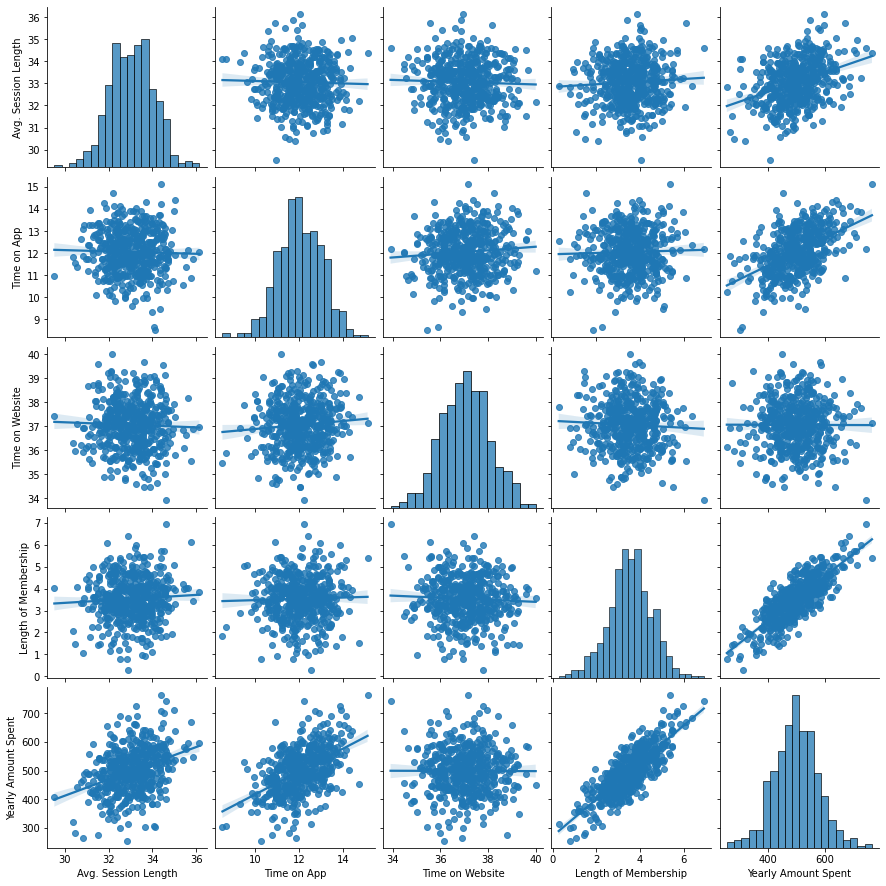

In [4]:
sns.pairplot(df, kind = "reg")

# Analysis of Variable Types

It is necessary to determine the types of variables. Thus, we can determine the types of the variables and make them suitable for the model.

It gives the names of the numeric, categorical but cardinal variables in the data set.

> cat_cols: Categorical variable list

> num_cols: Numeric variable list

> cat_but_car: Categorical but cardinal variable list

The function named grab_col_names helps to determine the types of variables.

In [5]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)



Observations: 500
Variables: 5
cat_cols: 0
num_cols: 5
cat_but_car: 0
num_but_cat: 0


# Outlier Analysis

Values that go far beyond the general trend in the data are called outliers. Especially in linear methods, the effects of outliers are more severe.Outliers cause bias in the data set.For all these reasons, it needs to be analyzed.

In [6]:
def outlier_thresholds(dataframe, col_name, q1=0.10, q3=0.90):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
for col in num_cols:
    print(col, check_outlier(df, col))

Avg. Session Length False
Time on App False
Time on Website False
Length of Membership False
Yearly Amount Spent False


# Analysis Of Missing Values

Missing values may cause problems while setting up the model. It must be detected and necessary actions must be taken.

No missing values were found for the relevant data.

In [7]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


# Correlation Analysis

Values with high correlation affect the target variable to a similar extent. Therefore, we can eliminate one of the variables with high correlation between two variables and use the other.

When the data was examined, no variable with a high correlation of more than 90% was found.

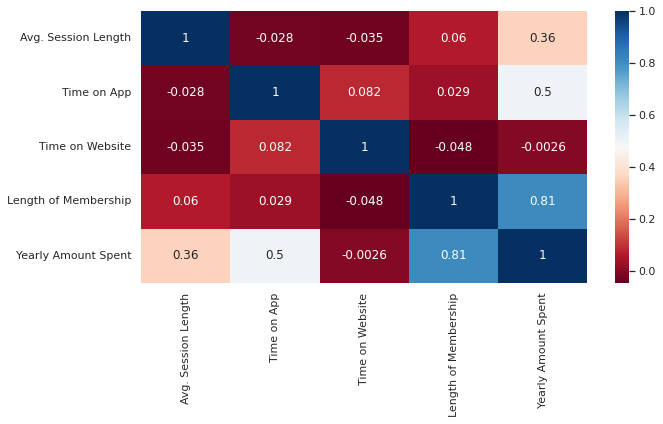

[]

In [8]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.90):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (10, 5)})
        sns.heatmap(corr, cmap="RdBu", annot=True)
        plt.show(block=True)
    return drop_list


high_correlated_cols(df,plot=True)

# LINEAR REGRESSION

Linear regression models the relationship between dependent and independent variable/variables linearly.

Linear regression is used to determine the character and strength of the relationship between the dependent variable and a number of other independent variables. It can also help a company build models to predict stock price.

In order to create the model, dependent and independent variables were defined.

In [9]:
X = df.drop('Yearly Amount Spent', axis=1) 

y = df[["Yearly Amount Spent"]]

# Building the Model

A train and test set by dividing the data into two is created . By training the model with one part and testing the model with the other part, it can be determined how successful the model is.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

reg_model = LinearRegression().fit(X_train, y_train)

# constant (b - bias)
print(reg_model.intercept_)

# coefficients (w - weights)
print(reg_model.coef_)

[-1047.73920526]
[[25.78854257 38.85150472  0.25638467 61.49204989]]


**Prediction of dependent variable**

In [11]:
y_pred = reg_model.predict(X_test)

# Evaluating Forecast Success

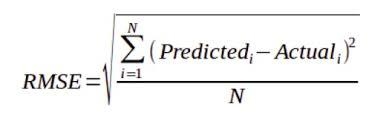

RMSE : 

In [12]:
np.sqrt(mean_squared_error(y_test, y_pred))

8.848486313500231

The ratio of independent variables description of dependent variable

In [13]:
reg_model.score(X_test, y_test)

0.9892888134002331

# Visualization of the Model

Finally, the actual values corresponding to the predicted values of the model are shown in the graph.

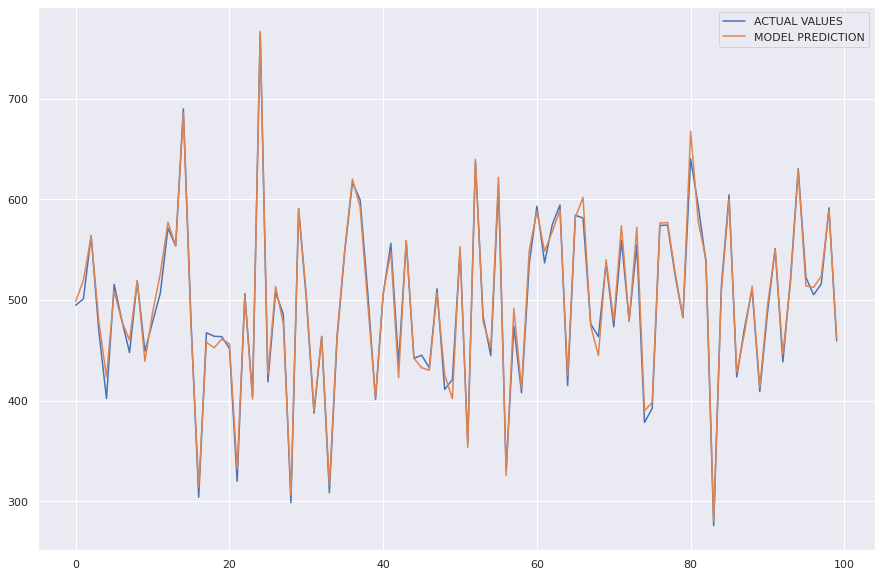

In [14]:
y_pred = pd.DataFrame(y_pred)
y_test = y_test.reset_index(drop=True)
df_ = pd.concat([y_test,y_pred], axis=1)
df_.columns = ["y_test","y_pred"]
plt.figure(figsize=(15,10))
plt.plot(df_)
plt.legend(["ACTUAL VALUES" , "MODEL PREDICTION"])

Source:
 
https://www.miuul.com/                                                                                     
https://www.veribilimiokulu.com/seaborn-ile-veri-gorsellestirmesi/                                                                                
https://www.dataquest.io/blog/understanding-regression-error-metrics/                                                                                       
https://www.geeksforgeeks.org/root-mean-square-error-in-r-programming/